In [1]:
##############################################################################
# CARGAR LIBRERIAS
##############################################################################

#Librerias
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
##############################################################################
# CARGAR DATOS
##############################################################################

datos = pd.read_excel("/content/drive/MyDrive/DIPLOMADO/DIFERENCIA/datos/datos_restaurante.xlsx")
datos.head()


,Compra,Propina,Cliente,Casada,Dia,Jornada,Grupo
0,82401.5,4898.5,Mujer,No,Miercoles,Noche,2
1,50149.0,8051.0,Hombre,No,Miercoles,Noche,3
2,101898.5,16975.0,Hombre,No,Miercoles,Noche,3
3,114848.0,16053.5,Hombre,No,Miercoles,Noche,2
4,119261.5,17508.5,Mujer,No,Miercoles,Noche,4


In [3]:
##############################################################################
# PRUEBA DE NORMALIDAD Y HOMOCEDASTICIDAD
##############################################################################

# Prueba de Normalidad (Shapiro-Wilk)
shapiro_results = {}
for dia in datos['Dia'].unique():
    stat, p_value = stats.shapiro(datos[datos['Dia'] == dia]['Compra'])
    shapiro_results[dia] = (stat, p_value)
print("Prueba de Normalidad (Shapiro-Wilk):")
for dia, result in shapiro_results.items():
    print(f"Dia {dia}: Estadístico = {result[0]}, p-valor = {result[1]}")

print("")

# Prueba de Normalidad (Kolmogorov-Smirnov)
kolmogorov_results = {}
for dia in datos['Dia'].unique():
    data = datos[datos['Dia'] == dia]['Compra']
    mean, std = data.mean(), data.std()
    stat, p_value = stats.kstest(data, 'norm', args=(mean, std))
    kolmogorov_results[dia] = (stat, p_value)

print("Prueba de Normalidad (Kolmogorov-Smirnov):")
for dia, result in kolmogorov_results.items():
    print(f"Dia {dia}: Estadístico = {result[0]}, p-valor = {result[1]}")


# Prueba de Homocedasticidad (Levene)
grouped_values = datos.groupby('Dia')['Compra'].apply(list).tolist()
levene_stat, levene_p = stats.levene(*grouped_values)
print("\nPrueba de Homocedasticidad (Levene):")
print(f"Estadístico = {levene_stat}, p-valor = {levene_p}")

Prueba de Normalidad (Shapiro-Wilk):
Dia Miercoles: Estadístico = 0.9479385478718797, p-valor = 0.003565796062703902
Dia Sabado: Estadístico = 0.9034752977450673, p-valor = 7.991754612612352e-06
Dia Jueves: Estadístico = 0.8844888694104515, p-valor = 2.857159087587016e-05
Dia Viernes: Estadístico = 0.8957935173266691, p-valor = 0.04085649671549424

Prueba de Normalidad (Kolmogorov-Smirnov):
Dia Miercoles: Estadístico = 0.11893620913847719, p-valor = 0.21477523288516914
Dia Sabado: Estadístico = 0.14653454414160494, p-valor = 0.04286714242890848
Dia Jueves: Estadístico = 0.1393615987897967, p-valor = 0.16353950118898186
Dia Viernes: Estadístico = 0.22410113681053084, p-valor = 0.2549577940558019

Prueba de Homocedasticidad (Levene):
Estadístico = 0.665357827988159, p-valor = 0.5740792267812252


In [4]:
##############################################################################
# DOS GRUPOS
##############################################################################

# Extraer datos de los grupos
data_a = datos[datos['Cliente'] == 'Mujer']['Compra']
data_b = datos[datos['Cliente'] == 'Hombre']['Compra']

# Realizar la prueba t-Student
t_result = stats.ttest_ind(data_a, data_b)
print("Resultado t-Student:")
print(f"t-statistic: {t_result.statistic}, p-value: {t_result.pvalue}")

print("")

# Realizar la prueba U de Mann Whitney
UmannWhitney = stats.mannwhitneyu(data_a, data_b, alternative='two-sided')
print("Resultado U de Mann Whitney:")
print(f"U-statistic: {UmannWhitney.statistic}, p-value: {UmannWhitney.pvalue}")

Resultado t-Student:
t-statistic: -2.277794028980312, p-value: 0.023611666846859506

Resultado U de Mann Whitney:
U-statistic: 5613.5, p-value: 0.021350332087987117


In [5]:
##############################################################################
# MÁS DE DOS GRUPOS
##############################################################################

# Realizando ANOVA
model = ols('Compra ~ C(Dia)', data=datos).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("Resultado ANOVA:")
print(anova_table)

print("")

# Realizando la prueba de Tukey HSD
tukey = pairwise_tukeyhsd(endog=datos['Compra'], groups=datos['Dia'], alpha=0.05)
print("\nResultado de la prueba de Tukey HSD:")
print(tukey)

Resultado ANOVA:
                sum_sq     df         F    PR(>F)
C(Dia)    1.514711e+10    3.0  2.767479  0.042454
Residual  4.378601e+11  240.0       NaN       NaN


Resultado de la prueba de Tukey HSD:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1    group2    meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------------
   Jueves Miercoles  18077.2016 0.0668   -833.8512 36988.2544  False
   Jueves    Sabado  13379.3913 0.2374  -4986.6886 31745.4711  False
   Jueves   Viernes  -2576.1405 0.9957 -31552.8235 26400.5425  False
Miercoles    Sabado  -4697.8103 0.8968 -22048.0783 12652.4576  False
Miercoles   Viernes -20653.3421 0.2371 -48997.0727  7690.3885  False
   Sabado   Viernes -15955.5318 0.4541 -43938.5987 12027.5352  False
--------------------------------------------------------------------


In [6]:
##############################################################################
# MÁS DE DOS GRUPOS
##############################################################################
!pip install scikit_posthocs
import scikit_posthocs as sp

print("")


# KRUSKAL WALLIS
# Agrupando los valores por grupo y extrayendo como listas
grouped_values = datos.groupby('Dia')['Compra'].apply(list).tolist()
kruskal_result = stats.kruskal(*grouped_values)
print("Resultado Kruskal-Wallis:")
print(kruskal_result)

# Realizando la prueba de Dunn
dunn_result = sp.posthoc_dunn(datos, val_col='Compra', group_col='Dia', p_adjust='bonferroni')
print("\nResultado de la prueba de Dunn con ajuste de Bonferroni:")
print(dunn_result)


Resultado Kruskal-Wallis:
KruskalResult(statistic=10.403076391437086, pvalue=0.01543300820104127)

Resultado de la prueba de Dunn con ajuste de Bonferroni:
             Jueves  Miercoles    Sabado   Viernes
Jueves     1.000000   0.033249  0.296409  1.000000
Miercoles  0.033249   1.000000  1.000000  0.166506
Sabado     0.296409   1.000000  1.000000  0.600554
Viernes    1.000000   0.166506  0.600554  1.000000


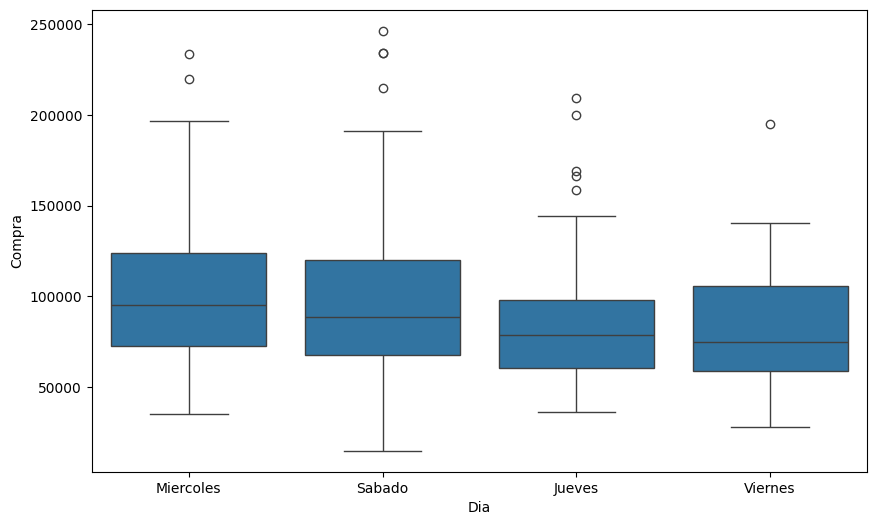

In [7]:
##############################################################################
# GRÁFICO DE BLOX PLOT
##############################################################################

plt.figure(figsize=(10, 6), dpi=100)
sns.boxplot(x='Dia', y='Compra', data=datos)
plt.xlabel('Dia')
plt.ylabel('Compra')
plt.show()